# Regridding for QDM-QPLAD EDA

This notebook was created to handle all regridding necessary for exploring the QDM-QPLAD approach using the forked Climate Impact Lab's forked version of `xclim`. This was due to many unsuccessful attempts to get environments straight with all the packages that would be needed for the entire effort, in particular, getting their version of `xclim` along with `xesmf` was eating up too much time, since we are really only going for a proof-of-concept with the methods here. So this notebook will simply rely on the `snap-geo` environment to perform all regridding, and the `explore_qplad.ipynb` will use the bare minimum of what is required to get the forked `xclim` package working. 

### Setup

Libs, paths, other constants:

In [1]:
from pathlib import Path
import numpy as np
import xesmf as xe
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
from pyproj import CRS, Transformer, Proj
from dask.distributed import LocalCluster, Client

# we will be focusing on 4km data for now
era5_dir = Path("/beegfs/CMIP6/wrf_era5/04km")
# directory where daily 4km is stored
era5_daily_dir = Path("/beegfs/CMIP6/kmredilla/era5_4km_daily")
# downscaling project directory for writing inputs/outputs
downscaling_dir = Path("/beegfs/CMIP6/kmredilla/downscaling")

## Getting the grids straight

Here we will explore the regridding steps that need to happen to implement the full QDM-QPLAD method! In the section below we will perform the full regridding needed for each step.

The Gergel methods perform 3 separate regriddings of the ERA5 data:

1. For QDM adjustment, it's regridded to the common grid using bilinear for temperature variables and conservative-area remapping for precipitation
2. For downscaling with QPLAD, it is regridded to a 0.25° × 0.25° regular lat–long grid
3. For QPLAD adjustment factors, common grid ERA5 is resampled (nearest neighbor regridded) to the 0.25° × 0.25° regular lat–long grid


Based on that, we will explore doing each of the following here with our 4km ERA5:

1. Regrid to common grid using bilinear for temperature variables and conservative-area remapping for precipitation
2. Regrid to target 12km 3338 grid
3. Resample common grid ERA5 via NN to target 12km 3338 grid

The target grid will simply be the 4km WRF grid but reprojected to 3338.

### 1. Regrid ERA5 to common grid

We will use xESMF to regrid from the WRF grid to the regular lat-long grid. Since the WRF file already has lat / lon, we can use it as-is.

Load a comming grid CMIP6 file:

In [13]:
coarse_grid_fp = Path(
    "/beegfs/CMIP6/kmredilla/cmip6_regridding/regrid/GFDL-ESM4/historical/Amon/tas/tas_Amon_GFDL-ESM4_historical_regrid_195001-195012.nc"
)

coarse_grid_ds = xr.open_dataset(coarse_grid_fp)

And a sample ERA5 file:

In [14]:
era5_tmp_fp = era5_dir.joinpath("2015/era5_wrf_dscale_4km_2015-12-26.nc")
era5_tmp_ds = xr.open_dataset(era5_tmp_fp)

And regrid from native ERA5 grid to common CMIP6 grid:

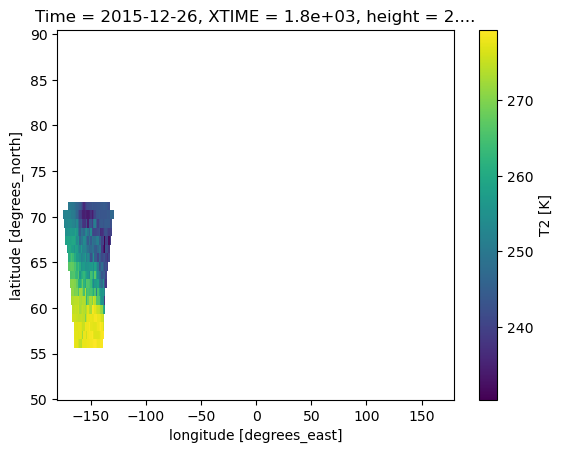

In [15]:
tmp_da = era5_tmp_ds["T2"].rename({"XLONG": "lon", "XLAT": "lat"})
era5_common_regridder = xe.Regridder(
    tmp_da, coarse_grid_ds, "bilinear", unmapped_to_nan=True
)
era5_tmp_common = era5_common_regridder(tmp_da, keep_attrs=True)
era5_tmp_common.isel(Time=0).plot()

### 2. Establish target grid 

We don't have a target grid defined at the moment, so we will make one! We can just use `rioxarray` to quickly reproject from the stereographic WRF projection to EPSG:3338. `rioxarray` is surely choosing sane defaults... :)

To do this reprojection, we will load the ancillary "geogrid" file from WRF and compute the grid coordinates by transforming the grid center lat / lon and using the grid shape and pixel size to construct the coordinates.

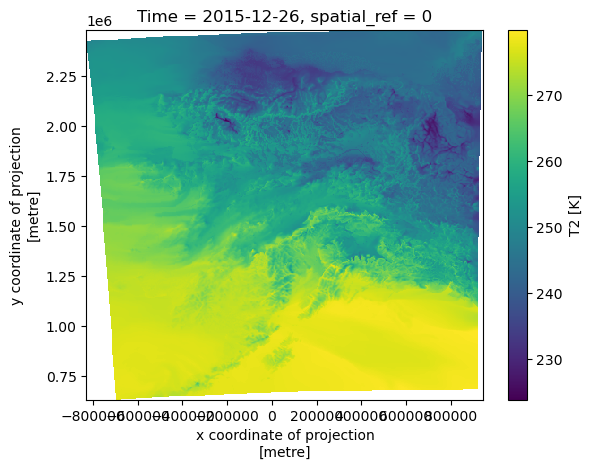

In [16]:
geo_ds = xr.open_dataset("/beegfs/CMIP6/wrf_era5/geo_em.d02.nc")

# The proj4 string for the WRF projection is:
# +proj=stere +units=m +a=6370000.0 +b=6370000.0 +lat_0=90.0 +lon_0=-152 +lat_ts=64 +nadgrids=@null
# this was determined separately using the WRF-Python package
# which has spotty availability / compatability
#
# here is the code for how that was done:
# wrf_proj = PolarStereographic(
#     **{"TRUELAT1": geo_ds.attrs["TRUELAT1"], "STAND_LON": geo_ds.attrs["STAND_LON"]}
# ).proj4()
wrf_proj = "+proj=stere +units=m +a=6370000.0 +b=6370000.0 +lat_0=90.0 +lon_0=-152 +lat_ts=64 +nadgrids=@null"

# WGS84 projection
wgs_proj = Proj(proj="latlong", datum="WGS84")
wgs_to_wrf_transformer = Transformer.from_proj(wgs_proj, wrf_proj)

# this is where we plug in the center longitude of the domain to get the center x, y in projected space
e, n = wgs_to_wrf_transformer.transform(
    geo_ds.attrs["CEN_LON"], geo_ds.attrs["TRUELAT1"]
)
# now compute the rest of the grid based on x/y dimension lengths and grid spacing
dx = dy = 4000
nx = era5_tmp_ds.XLONG.shape[1]
ny = era5_tmp_ds.XLONG.shape[0]
x0 = -(nx - 1) / 2.0 * dx + e
y0 = -(ny - 1) / 2.0 * dy + n
# 2d grid coordinate values
x = np.arange(nx) * dx + x0
y = np.arange(ny) * dy + y0

wrf_crs = CRS.from_proj4(wrf_proj)
era5_tmp_ds_proj = (
    era5_tmp_ds["T2"]
    .rename({"south_north": "y", "west_east": "x"})
    .assign_coords({"y": ("y", y), "x": ("x", x)})
    .drop_vars(["XLONG", "XLAT", "XTIME"])
    .rio.set_spatial_dims("x", "y")
    .to_dataset()
    .rio.write_crs(wrf_crs)
)

era5_tmp_3338 = era5_tmp_ds_proj.rio.reproject("EPSG:3338")
era5_tmp_3338.isel(Time=0).T2.plot()

### 3. Resample common grid ERA5 via NN to target 12km 3338 grid

Now that we have our common grid ERA5 as well as ERA5 on our target grid, we can use both to resample the common grid ERA5 to the target grid to get the third product, which is needed for the downscaling. 

In [17]:
# following gergel et al, this ERA5 data on the target grid is called the "fine" version.
era5_tmp_fine = era5_tmp_3338.T2

# wow copilot pretty much nailed it here
# BEGIN: Add irregular lat and lon variables
# Create a transformer from the WRF projection to WGS84
transformer_3338_to_4326 = Transformer.from_crs(3338, 4326)

# Transform the x and y coordinates to lat and lon
xx, yy = np.meshgrid(era5_tmp_fine["x"].values, era5_tmp_fine["y"].values)
lat, lon = transformer_3338_to_4326.transform(xx, yy)

# Add the lat and lon variables to the dataset
era5_tmp_fine = era5_tmp_fine.assign_coords(
    lon=(("y", "x"), lon), lat=(("y", "x"), lat)
)

Do the regridding:

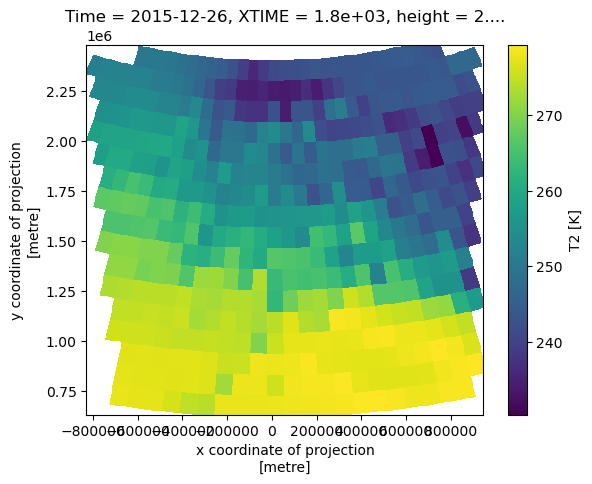

In [18]:
era5_coarse_regridder = xe.Regridder(
    era5_tmp_common, era5_tmp_fine, "nearest_s2d", unmapped_to_nan=True
)
era5_coarse = era5_coarse_regridder(era5_tmp_common, keep_attrs=True)
era5_coarse.isel(Time=0).plot()

## Regridding pipeline

This section will now implement the above regridding methods needed for each step. 

### Regridding for QDM adjustment: common grid


From the paper:

> GCM projections for each variable, GCM, experiment, pixel, year, and day at a 1◦ × 1◦ resolution are bias-adjusted using the xclim Python package QDM implementation (Logan et al., 2021). To do this, QDM models for each pixel and day of the year are trained on a rolling 31 d centered window (±15 d) of daily ERA5 and GCM historical data from 1995 to 2014. For ERA5 reference data, we include the last 15 d from 1994 and the first 15 d from 2015, such that each day group contains 620 values (20 years × 31 d). For CMIP6 historical data, since the simulation ends in 2014, we do not include the additional 15 d from 2015 or 1994 for consistency. Each trained QDM model (per pixel and day of year) has 100 equally spaced quantiles in our implementation. We used an additive adjustment for maximum and minimum temperature and a multiplicative adjustment for precipitation. Each variable was bias-adjusted separately.

So, load and regrid daily ERA5 data to the common grid.

Spin up a dask cluster:

In [8]:
# The threads_per_worker=1 seems to have really helped with open_mfdataset()
cluster = LocalCluster(threads_per_worker=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 40
Total threads: 40,Total memory: 187.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35537,Workers: 40
Dashboard: http://127.0.0.1:8787/status,Total threads: 40
Started: Just now,Total memory: 187.57 GiB
Comm: tcp://127.0.0.1:34763,Total threads: 1
Dashboard: http://127.0.0.1:42933/status,Memory: 4.69 GiB
Nanny: tcp://127.0.0.1:43885,


Iterate over all daily variables, regrid, and write to disk:

In [27]:
# initialize a list for storing each dataarray
era5_common_dses = []

# we need a lookup for the regridding method, as we will use different methods based on variable
interp_method_lut = {
    "t2max": "bilinear",
    "t2min": "bilinear",
    # "pr": "conservative",
    "pr": "bilinear",  # TO-DO: need to fix this in production!!
    # conservative regridding is not supported in this case because it needs corner information
    # and lat/lon vars are 2D
    # (https://xesmf.readthedocs.io/en/stable/user_api.html)
}

for var_id in ["t2max", "t2min", "pr"]:
    era5_fps = sorted(era5_daily_dir.glob(f"*{var_id}*.nc"))
    era5_ds = xr.open_mfdataset(era5_fps, parallel=True, engine="h5netcdf")

    era5_tmp_da = era5_ds.isel(time=0).load()

    interp_method = interp_method_lut[var_id]
    era5_common_regridder = xe.Regridder(
        era5_tmp_da, coarse_grid_ds, interp_method, unmapped_to_nan=True
    )
    era5_common_da = era5_common_regridder(era5_ds[var_id], keep_attrs=True)
    era5_common_dses.append(era5_common_da.to_dataset().drop_vars(["height"]))
    print(var_id, "done", end=", ")

t2max done, t2min done, pr done, 

Combine the variables into a single dataset (because it's small) and write to disk:

In [28]:
era5_common_ds = xr.merge(era5_common_dses)
era5_common_ds.to_netcdf(downscaling_dir.joinpath("era5_common.nc"))
era5_common_ds

<xarray.Dataset> Size: 1GB
Dimensions:      (time: 7335, lat: 43, lon: 288)
Coordinates:
  * time         (time) datetime64[ns] 59kB 1994-12-17 1994-12-18 ... 2015-01-15
  * lat          (lat) float64 344B 90.0 89.06 88.12 87.17 ... 52.3 51.36 50.42
  * lon          (lon) float64 2kB -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
    spatial_ref  int64 8B 0
Data variables:
    t2max        (time, lat, lon) float32 363MB dask.array<chunksize=(15, 43, 288), meta=np.ndarray>
    t2min        (time, lat, lon) float32 363MB dask.array<chunksize=(15, 43, 288), meta=np.ndarray>
    pr           (time, lat, lon) float32 363MB dask.array<chunksize=(15, 43, 288), meta=np.ndarray>

### Regridding for QPLAD

This section will perform the remaining two regridding steps: regridding the ERA5 to the target grid to create the $ERA5_{fine}$ data, and regridding the "common" grid ERA5 to the target grid to create the $ERA5_{coarse}$ data.

#### ERA5 "fine"

Here we will regrid the ERA5 to the target resolution to create the "fine" dataset. This will be done as above, by simply reprojecting to EPSG:3338 using rioxarray. 

This should take a few minutes on a compute node:

In [29]:
era5_fine_dses = []
for var_id in ["t2max", "t2min", "pr"]:
    era5_fps = sorted(era5_daily_dir.glob(f"*{var_id}*.nc"))
    era5_ds = xr.open_mfdataset(era5_fps, parallel=True, engine="h5netcdf")

    era5_tmp_ds_proj = (
        era5_ds[var_id]
        .rename({"south_north": "y", "west_east": "x"})
        .assign_coords({"y": ("y", y), "x": ("x", x)})
        .drop_vars(["lon", "lat"])
        .rio.set_spatial_dims("x", "y")
        .to_dataset()
        .rio.write_crs(wrf_crs)
    )

    era5_tmp_fine_ds = era5_tmp_ds_proj.rio.reproject("EPSG:3338")
    era5_fine_dses.append(era5_tmp_fine_ds)
    print(var_id, "done", end=", ")

t2max done, t2min done, pr done, 

In [30]:
era5_fine_ds = xr.merge(era5_fine_dses)
era5_fine_ds.to_netcdf(downscaling_dir.joinpath("era5_fine.nc"))
era5_fine_ds

<xarray.Dataset> Size: 18GB
Dimensions:      (x: 443, y: 460, time: 7335)
Coordinates:
  * x            (x) float64 4kB -8.277e+05 -8.237e+05 ... 9.402e+05 9.442e+05
  * y            (y) float64 4kB 2.476e+06 2.472e+06 ... 6.402e+05 6.362e+05
  * time         (time) datetime64[ns] 59kB 1994-12-17 1994-12-18 ... 2015-01-15
    spatial_ref  int64 8B 0
Data variables:
    t2max        (time, y, x) float32 6GB nan nan nan nan ... nan nan nan nan
    t2min        (time, y, x) float32 6GB nan nan nan nan ... nan nan nan nan
    pr           (time, y, x) float32 6GB nan nan nan nan ... nan nan nan nan

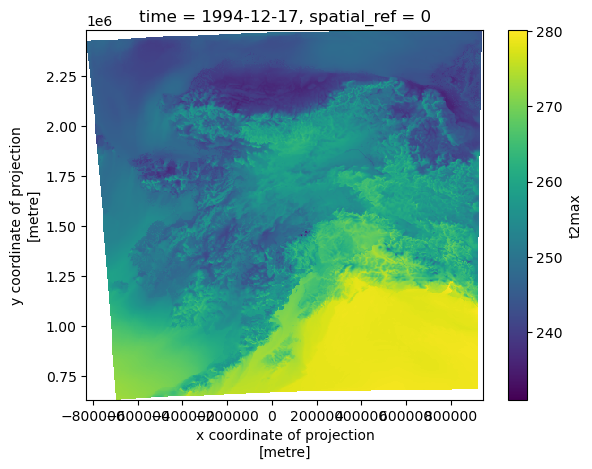

In [31]:
# sample plot
era5_fine_ds.t2max.isel(time=0).plot()

#### ERA5 "coarse"

Now we can take that common grid ERA5 dataset and make the "coarse" ERA5 by performing a nearest-neighbor resampling to the target grid. We will just reuse the regridder object created in section 3 above:

In [24]:
era5_coarse = era5_coarse_regridder(era5_common_ds, keep_attrs=True)
era5_coarse

<xarray.Dataset> Size: 18GB
Dimensions:      (time: 7335, y: 460, x: 443)
Coordinates:
  * time         (time) datetime64[ns] 59kB 1994-12-17 1994-12-18 ... 2015-01-15
    spatial_ref  int64 8B 0
  * x            (x) float64 4kB -8.277e+05 -8.237e+05 ... 9.402e+05 9.442e+05
  * y            (y) float64 4kB 2.476e+06 2.472e+06 ... 6.402e+05 6.362e+05
    lon          (y, x) float64 2MB -176.7 -176.6 -176.5 ... -139.3 -139.2
    lat          (y, x) float64 2MB 70.99 71.01 71.02 71.03 ... 54.8 54.8 54.79
Data variables:
    t2max        (time, y, x) float32 6GB dask.array<chunksize=(15, 460, 443), meta=np.ndarray>
    t2min        (time, y, x) float32 6GB dask.array<chunksize=(15, 460, 443), meta=np.ndarray>
    pr           (time, y, x) float32 6GB dask.array<chunksize=(15, 460, 443), meta=np.ndarray>
Attributes:
    regrid_method:  nearest_s2d

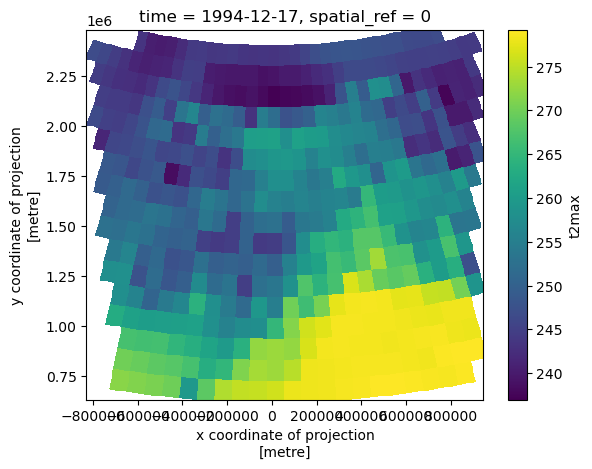

In [25]:
# sample plot
era5_coarse.t2max.isel(time=0).plot()

This will take a tiny bit longer to write as it is higher res

In [26]:
era5_coarse.to_netcdf(downscaling_dir.joinpath("era5_coarse.nc"))

And that's all the regridding we should have to do at this stage.

#### Bias-adjusted GCM data --> target grid

Now we need to regrid the adjusted GCM to the target grid for the QPLAD downscaling.

In [52]:
year = 2000
hist_adj_fp = downscaling_dir.joinpath(
    f"GFDL-ESM4_historical_tasmax_{year}_adjusted.nc"
)
# want this to be a variable being regridded
hist_adj = xr.open_dataset(hist_adj_fp).reset_coords("sim_q", drop=False)

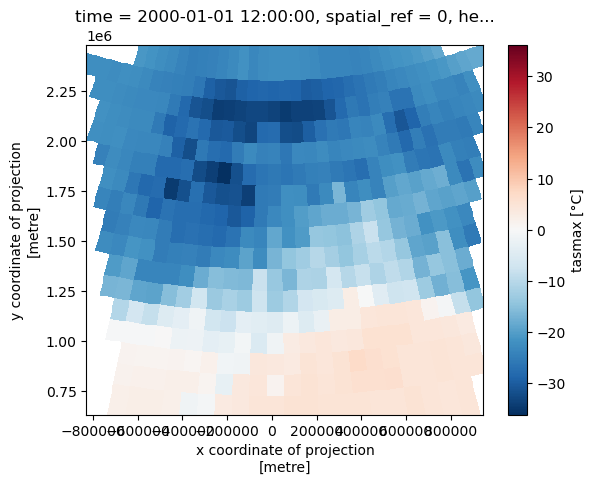

In [53]:
era5_fine_fp = downscaling_dir.joinpath("era5_fine.nc")
era5_fine = xr.open_dataset(era5_fine_fp)

# wow copilot pretty much nailed it here
# BEGIN: Add irregular lat and lon variables
# Create a transformer from the WRF projection to WGS84
transformer_3338_to_4326 = Transformer.from_crs(3338, 4326)

# Transform the x and y coordinates to lat and lon
xx, yy = np.meshgrid(era5_fine["x"].values, era5_fine["y"].values)
lat, lon = transformer_3338_to_4326.transform(xx, yy)

# Add the lat and lon variables to the dataset
era5_fine = era5_fine.assign_coords(lon=(("y", "x"), lon), lat=(("y", "x"), lat))

sim_adj_regridder = xe.Regridder(
    hist_adj, era5_fine, "nearest_s2d", unmapped_to_nan=True
)
hist_adj_fine = sim_adj_regridder(hist_adj, keep_attrs=True)
hist_adj_fine["tasmax"].isel(time=0).plot()

In [56]:
hist_adj_fine_fp = downscaling_dir.joinpath(
    f"GFDL-ESM4_historical_tasmax_{year}_adjusted_fine.nc"
)
hist_adj_fine_fp.unlink()
hist_adj_fine.to_netcdf(hist_adj_fine_fp)